# Sentiment analysis with BERT

In [1]:
# Google colab, once
# !pip install imblearn
# !wget "https://raw.githubusercontent.com/marciobda/PortugueseEmotionRecognitionWeakSupervision/refs/heads/main/test.csv"

In [ ]:
#general purpose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

#data processing
import re, string

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#transformers
from transformers import AutoTokenizer
from transformers import TFBertModel

#keras
import tensorflow as tf

#metrics
from sklearn.metrics import classification_report, confusion_matrix

#seed for reproducibility
SEED = 42

MODEL_NAME = 'bertimbau_30_mask'

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-v0_8")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


2024-11-13 02:09:51.708964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731474591.779898  590338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731474591.799037  590338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 02:09:51.969771: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<Figure size 640x480 with 0 Axes>

In [3]:
emotions = ['Admiração', 'Diversão', 'Raiva', 'Aborrecimento', 'Aprovação', 'Confusão', 'Curiosidade', 'Desejo', 'Decepção', 'Nojo', 'Vergonha', 'Entusiasmo', 'Medo', 'Gratidão', 'Luto', 'Alegria', 'Amor', 'Nervosismo', 'Otimismo', 'Orgulho', 'Alívio', 'Remorso', 'Tristeza', 'Surpresa', 'Saudade', 'Inveja', 'Compaixão', 'Desaprovação']

In [4]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(40,40))
    labels=emotions
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":20})
    plt.title(title, fontsize=30)
    ax.xaxis.set_ticklabels(labels, fontsize=20) 
    ax.yaxis.set_ticklabels(labels, fontsize=20)
    ax.set_ylabel('Test', fontsize=22)
    ax.set_xlabel('Predicted', fontsize=22)
    plt.show()


## Loading the data

In [ ]:
df = pd.read_csv('./../train_30_mask.csv', sep='\t', quoting=3 , engine='python')
df = df.dropna()
df.head()

,tweet_id,tweet,categoria
0,1407463675905167370,"Quem é esse rei ja virei fã, a lenda so falou ...",1
1,1407447387472334852,Finalmente dei uma faxina bonita na casa! A se...,0
2,1407508991303892993,A incrível arte de flertar com várias pessoas ...,0
3,1407473645983764480,"Babo muito em Thaylane cr, q preta maravilhosa",0
4,1407916016278163456,Bolo da minha tia ficou muito feio mas oq tinh...,26


In [6]:
df_test = pd.read_csv('./../test.csv', sep='\t', quoting=3 , engine='python')
df_test = df_test.dropna()
df_test.head()

,tweet_id,tweet,categoria
0,1407769371955634180,nossa sério eu daria tudo p saber das fofocas ...,6
1,1407860353598427138,Sem palavras p agradecer tudo o que tem aconte...,13
2,1407855425782005771,tava respondendo tudo isso na minha cabeça e m...,12
3,1407740654428561414,eu achei que era possível terminar sem pegar n...,5
4,1407865324989521921,Sim mas n o amor romântico,16


### Remove duplicated tweets

In [7]:
df.info()
df.drop_duplicates(subset='tweet', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10612 entries, 0 to 10728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   10612 non-null  object
 1   tweet      10612 non-null  object
 2   categoria  10612 non-null  object
dtypes: object(3)
memory usage: 331.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 10525 entries, 0 to 10728
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   10525 non-null  object
 1   tweet      10525 non-null  object
 2   categoria  10525 non-null  object
dtypes: object(3)
memory usage: 328.9+ KB


In [8]:
df_test.info()
df_test.drop_duplicates(subset='tweet', inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2657 entries, 0 to 2681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2657 non-null   int64 
 1   tweet      2657 non-null   object
 2   categoria  2657 non-null   object
dtypes: int64(1), object(2)
memory usage: 83.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2648 entries, 0 to 2681
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2648 non-null   int64 
 1   tweet      2648 non-null   object
 2   categoria  2648 non-null   object
dtypes: int64(1), object(2)
memory usage: 82.8+ KB


## Tweets analysis

In [9]:
df = df[['tweet', 'categoria']]

In [10]:
# Remove punctuations, links, mentions and \r\n new line characers
def strip_all_entities(text):
    text = text.replace('\r','').replace('\n',' ').lower()
    text = re.sub(r'(?:\@|https?\://)\S+', '',text)
    text = re.sub(r'[^\x00-\x7f]','', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'

    banned_list = string.punctuation

    table = str.maketrans('','',banned_list)
    text = text.translate(table)

    return text

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    sent = []
    for word in text.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r'\s\s+', ' ', text)

In [ ]:
new_texts = []

for text in df.tweet:
    new_texts.append(remove_mult_spaces(filter_chars(strip_all_entities(text))))

df['clean_tweet'] = df.tweet

In [ ]:
new_texts_test = []

for text in df_test.tweet:
    new_texts.append(remove_mult_spaces(filter_chars(strip_all_entities(text))))

df_test['clean_tweet'] = df_test.tweet

In [13]:
df['clean_tweet'].head()
df_test['clean_tweet'].head()

0    nossa sério eu daria tudo p saber das fofocas ...
1    Sem palavras p agradecer tudo o que tem aconte...
2    tava respondendo tudo isso na minha cabeça e m...
3    eu achei que era possível terminar sem pegar n...
4                           Sim mas n o amor romântico
Name: clean_tweet, dtype: object

### Token analysis

In [14]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

In [15]:
token_lens = []

for text in df['clean_tweet'].values:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)
max_len

153

In [16]:
token_lens = []

for text in df_test['clean_tweet'].values:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)
max_len

152

In [17]:
df = df.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

## Emotion category analysis

In [18]:
df['categoria'].value_counts()

categoria
5        1189
1         874
7         798
2         740
0         545
13        541
22        494
12        469
16        419
23        339
26        305
18        303
20        300
17        287
15        273
9         270
6         263
8         252
3         248
24        244
21        243
11        232
19        216
25        177
27        172
4         148
10        147
14         28
11,15       5
11,17       1
18,19       1
16,17       1
12,13       1
Name: count, dtype: int64

In [19]:
df_test['categoria'].value_counts()

categoria
5        320
7        222
1        204
2        193
0        134
12       126
13       117
22       109
16       108
26        88
23        81
18        76
20        73
17        73
6         69
9         67
15        66
11        61
24        60
19        60
21        58
8         57
3         50
10        45
4         44
27        43
25        36
14         7
20,21      1
Name: count, dtype: int64

In [20]:
df['categoria'] = df['categoria'].apply(ast.literal_eval)
df = df.explode('categoria')

In [21]:
df_test['categoria'] = df_test['categoria'].apply(ast.literal_eval)
df_test = df_test.explode('categoria')

In [22]:
df['categoria'].value_counts()

categoria
5     1189
1      874
7      798
2      740
0      545
13     542
22     494
12     470
16     420
23     339
26     305
18     304
20     300
17     289
15     278
9      270
6      263
8      252
3      248
24     244
21     243
11     238
19     217
25     177
27     172
4      148
10     147
14      28
Name: count, dtype: int64

In [23]:
df_test['categoria'].value_counts()

categoria
5     320
7     222
1     204
2     193
0     134
12    126
13    117
22    109
16    108
26     88
23     81
18     76
20     74
17     73
6      69
9      67
15     66
11     61
24     60
19     60
21     59
8      57
3      50
10     45
4      44
27     43
25     36
14      7
Name: count, dtype: int64

### Train - Validation - Test split

In [24]:
VALIDATION_RATIO = 0.15
TEST_RATIO = 0.10

X_train =  df['clean_tweet']
X_test =  df_test['clean_tweet']
y_train = df['categoria'].astype(str)
y_test = df_test['categoria'].astype(str)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test ,test_size= TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO), random_state=SEED)

print(df.shape, X_train.size, X_valid.size, X_test.size)

(10534, 3) 10534 1589 1060


### One hot encoding

In [25]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1,1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

## BERT Emotion analysis

In [26]:
lexical_items = pd.read_csv('./../lexical_items.csv')
lexical_items_array = np.array(lexical_items)

In [ ]:
MAX_LEN = 128

def tokenize(data, max_len=MAX_LEN, mask_probability=0):
    input_ids = []
    attention_masks = []

    # Convert to list if it's a DataFrame/Series
    if hasattr(data, 'values'):
        data = data.values.tolist()

    for text in data:

        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',  # Added for consistency
            truncation=True,       # Added for safety
            return_attention_mask=True
        )

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [29]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN, MASK_PROABILITY)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

### BERT modeling

In [30]:
bert_model = TFBertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

I0000 00:00:1731474767.841335  590338 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0c:00.0, compute capability: 8.6
Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/bias:

In [31]:
def create_model(bert_model, max_len=MAX_LEN):

    ## params ##
    opt = tf.keras.optimizers.AdamW(learning_rate=5e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len), dtype='int32')
    attention_maks = tf.keras.Input(shape=(max_len), dtype='int32')

    embeddings = bert_model([input_ids, attention_maks])[1]

    output = tf.keras.layers.Dense(28, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs=[input_ids, attention_maks], outputs=output)
    
    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [32]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1089231   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   36         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [33]:
history_bert = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([val_input_ids, val_attention_masks], y_valid),
    epochs=4,
    batch_size=16
    )

Epoch 1/4


I0000 00:00:1731474790.111721  591685 service.cc:148] XLA service 0x7f952c75a370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731474790.111969  591685 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-11-13 02:13:10.124228: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731474790.147868  591685 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1731474790.214595  591685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


659/659 [==============================] - 151s 188ms/step - loss: 1.8036 - categorical_accuracy: 0.5334 - val_loss: 1.0063 - val_categorical_accuracy: 0.7514
Epoch 2/4
659/659 [==============================] - 118s 180ms/step - loss: 1.1155 - categorical_accuracy: 0.7069 - val_loss: 0.9684 - val_categorical_accuracy: 0.7665
Epoch 3/4
659/659 [==============================] - 118s 180ms/step - loss: 0.7038 - categorical_accuracy: 0.8090 - val_loss: 1.0887 - val_categorical_accuracy: 0.7539
Epoch 4/4
659/659 [==============================] - 118s 178ms/step - loss: 0.3950 - categorical_accuracy: 0.8900 - val_loss: 1.2204 - val_categorical_accuracy: 0.7514


### BERT Results

In [34]:
result_bert = model.predict([test_input_ids,test_attention_masks])

34/34 [==============================] - 5s 96ms/step


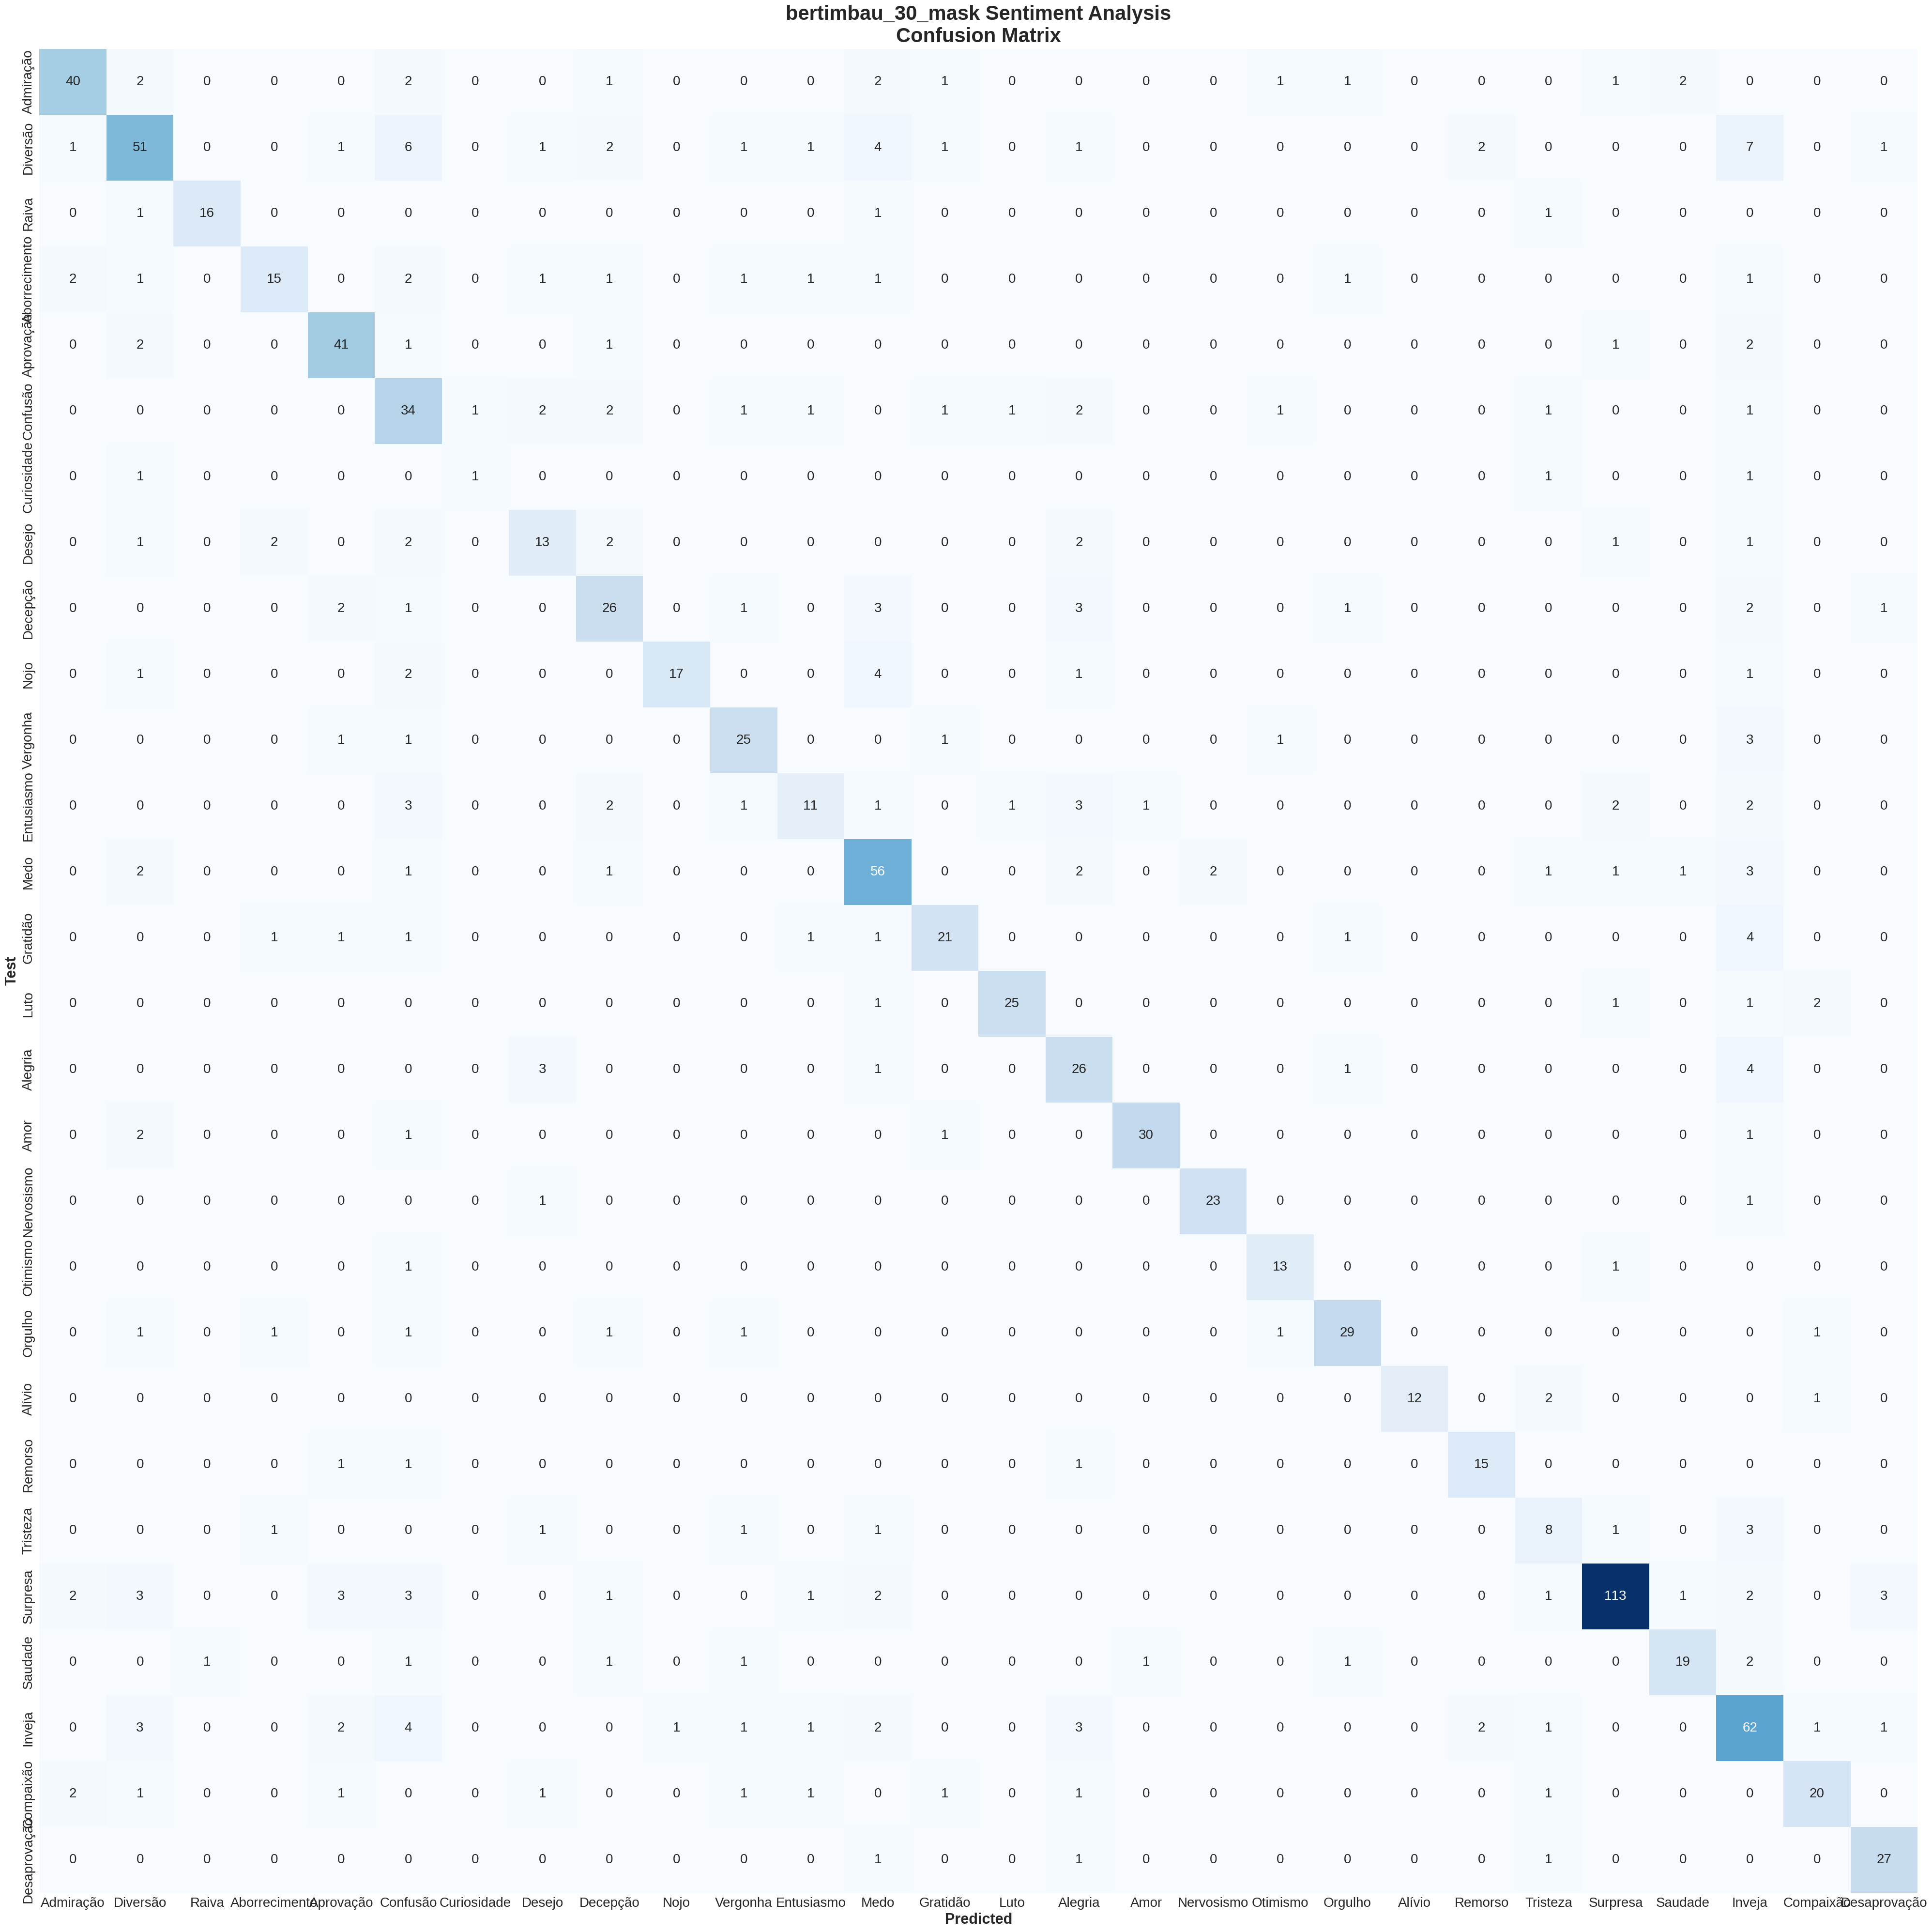

In [35]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),f'{MODEL_NAME} Sentiment Analysis\nConfusion Matrix')

In [36]:
print(f'\tClassification Report for {MODEL_NAME}:\n\n',classification_report(y_test, y_pred_bert, target_names=emotions))

	Classification Report for bertimbau_30_mask:

                precision    recall  f1-score   support

    Admiração       0.85      0.75      0.80        53
     Diversão       0.71      0.64      0.67        80
        Raiva       0.94      0.84      0.89        19
Aborrecimento       0.75      0.56      0.64        27
    Aprovação       0.77      0.85      0.81        48
     Confusão       0.50      0.71      0.59        48
  Curiosidade       0.50      0.25      0.33         4
       Desejo       0.57      0.54      0.55        24
     Decepção       0.63      0.65      0.64        40
         Nojo       0.94      0.65      0.77        26
     Vergonha       0.71      0.78      0.75        32
   Entusiasmo       0.61      0.41      0.49        27
         Medo       0.69      0.80      0.74        70
     Gratidão       0.78      0.68      0.72        31
         Luto       0.93      0.83      0.88        30
      Alegria       0.57      0.74      0.64        35
         Amor   

### Saving the model

In [37]:
# import os

# model_save_path = f'{MODEL_NAME}_model'
# os.makedirs(model_save_path, exist_ok=True)

# model.save(model_save_path)
# tokenizer.save_pretrained(model_save_path)

### Testing the model

In [38]:
def prepare_text(text, tokenizer, max_len=128):

    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

    return encoded_text['input_ids'], encoded_text['attention_mask']

def predict_category(text, model, tokenizer, label_encoder):

    input_ids, attention_mask = prepare_text(text, tokenizer)

    predictions = model.predict([input_ids, attention_mask])

    # Create a zero array with proper dimensions
    one_hot = np.zeros(28)  # 28 is the number of categories
    # Set 1 at the predicted class index
    one_hot[predictions.argmax(axis=-1)[0]] = 1
    # Reshape to match OneHotEncoder's expected format
    one_hot = one_hot.reshape(1, -1)
    
    # Convert back to original category
    predicted_label = ohe.inverse_transform(one_hot)[0]

    return emotions[int(predicted_label[0])]

In [ ]:
text = "Eu estou empolgado com o trabalho"
predicted_category = predict_category(text, model, tokenizer, ohe)

print(f"Predicted categoy: {predicted_category}")

1/1 [==============================] - 2s 2s/step
Predicted categoy: Entusiasmo
